In [1]:
import os
import sys
import time
import glob
import io
import pytesseract
from pytesseract import Output
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import layoutparser

In [2]:
nb_dir = '/home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src'
sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

import config
import src.utilities.app_context as app_context
from src.utilities.primalaynet.infer import draw_box
app_context.init()
app_context.application_context = dict({'task_id': 'BM-DUMMY'})

#path to craft model, weight can be pulled form the production bracnh of repo
config.CRAFT_MODEL_PATH = "/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_mlt_25k.pth"
config.CRAFT_REFINE_MODEL_PATH   =  "/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_refiner_CTW1500.pth"
from src.services.main import generate_response,break_blocks,merge_vertically,merge_horizontally,extract_images_and_text_regions

Loading weights of refiner from checkpoint (./model/craft_refiner_CTW1500.pth)


In [3]:
import layoutparser as lp
model_primalaynet = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',label_map = {1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"},extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5])


In [4]:
def draw_box(filepath,desired_width, desired_height,save_dir, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    if type(df) is list:
        for i in df:
            for index, row in i.iterrows():
                left   = int(row['text_left'])
                right  = int(row['text_width'] + left)
                top    = int(row['text_top'])
                bottom = int(row["text_height"] + top)
                draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    else:

        for index, row in df.iterrows():
            left   = int(row['text_left'])
            right  = int(row['text_width'] + left)
            top    = int(row['text_top'])
            bottom = int(row["text_height"] + top)
            draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    save_filepath = os.path.join(save_dir, os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

In [5]:
#dir which contains the pdf file
input_dir = '/home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/'
filename = '20806_2017_3_1501_8673_Judgement_31-Aug-2018_BEN.pdf'
lang     = 'bn'

In [6]:
[pdf_data,flags] = extract_images_and_text_regions(filename, input_dir,lang,page_layout='single_column')
[pdf_data,flags] = merge_horizontally([pdf_data,flags])
[pdf_data,flags] = merge_vertically([pdf_data,flags])
[pdf_data,flags] = break_blocks([pdf_data,flags])
#response        = generate_response([pdf_data,flags])

[2021-01-08 14:00:00,331] {loghandler.py:20} MainThread INFO in loghandler: document preprocessing started ===>
[2021-01-08 14:00:00,334] {loghandler.py:20} MainThread INFO in loghandler: created processing directories successfully /home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/20806_2017_3_1501_8673_Judgement_31-Aug-2018_BEN_b294ec8e-518b-11eb-98de-38baf82f7425
[2021-01-08 14:00:00,337] {loghandler.py:20} MainThread INFO in loghandler: filepath /home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/20806_2017_3_1501_8673_Judgement_31-Aug-2018_BEN.pdf, working_dir /home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/20806_2017_3_1501_8673_Judgement_31-Aug-2018_BEN_b294ec8e-518b-11eb-98de-38baf82f7425
[2021-01-08 14:00:00,956] {loghandler.py:20} MainThread INFO in loghandler: Extracting xml of /home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sam

In [ ]:
flags

In [ ]:
def predict_primanet(image_path,bg_image_path,in_df,width_ratio,height_ratio):
    image1  = cv2.imread(image_path)
    image2  = cv2.imread(bg_image_path)
    image = image1[..., ::-1] 
    layout = model_primalaynet.detect(image)
    boxes,coords = draw_box(layout, in_df,width_ratio,height_ratio)

    final_coord= []
    for coord in coords:
        temp_dict={}
        temp_dict['text_left']=coord[0]; temp_dict['text_top']=coord[1]
        temp_dict['text_width']=coord[2]; temp_dict['text_height']=coord[3]
        #draw.rectangle(coord, width=3,outline='red')
        final_coord.append(temp_dict)
        cv2.rectangle(image1, (int(coord[0]),int(coord[1])), (int(coord[2]),int(coord[3])),(255,255,0),3)
        cv2.rectangle(image2, (int(coord[0]*width_ratio),int(coord[1]*height_ratio)), (int(coord[2]*width_ratio),int(coord[3]*height_ratio)),(255,255,0),3)

        cv2.imwrite("1.jpg",image1)
        cv2.imwrite("2.jpg",image2)

    return final_coord

In [ ]:
width_ratio = pdf_data['page_width'] / pdf_data['pdf_image_width']
height_ratio = pdf_data['page_height'] / pdf_data['pdf_image_height']
predict_primanet(img_filepath,pdf_bg_img_filepaths,to_check[0],width_ratio,height_ratio)

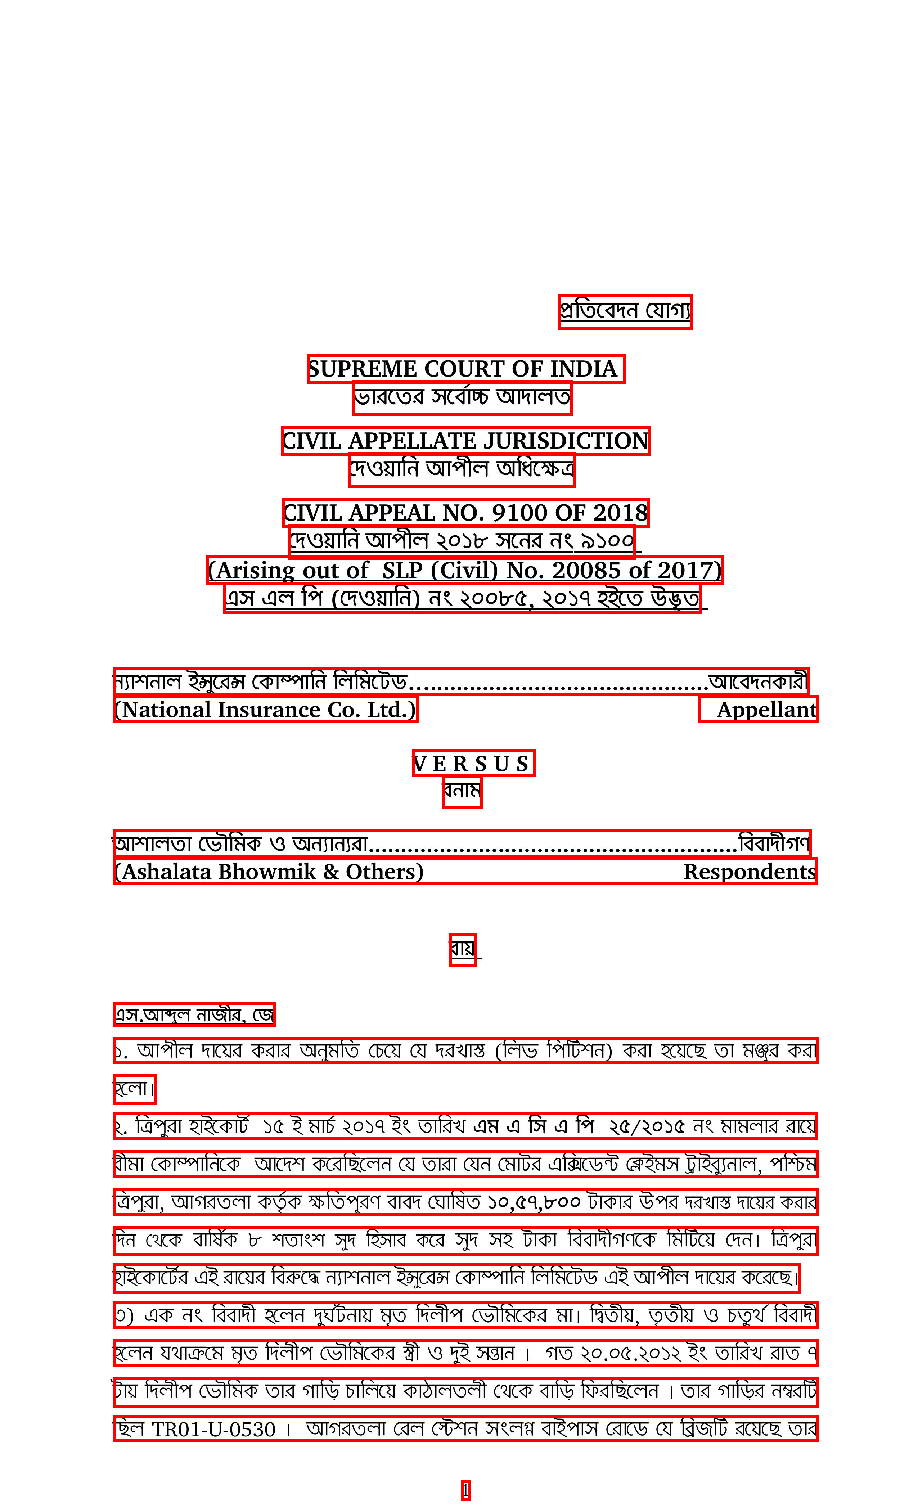

In [7]:
page_index = 0
to_check        = pdf_data['h_dfs']
#to_check_in_df        = pdf_data['v_dfs'][page_index]
img_filepath    = pdf_data['pdf_image_paths'][page_index]
pdf_bg_img_filepaths  = pdf_data['pdf_bg_img_filepaths'][page_index]
df              = to_check[page_index]

desired_width, desired_height = pdf_data['page_width'] , pdf_data['page_height']
draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)

In [8]:
df.text.values

array([' প্রতিবেদন যোগ্য', ' SUPREME COURT OF INDIA',
       'ভারতের সর্বোচ্চ আদালত', ' CIVIL APPELLATE JURISDICTION',
       ' দেওয়ানি আপীল অধিক্ষেত্র', ' CIVIL APPEAL NO. 9100 OF 2018',
       ' দেওয়ানি আপীল ২০১৮ সনের নং ৯১০০',
       ' (Arising out of SLP (Civil) No. 20085 of 2017)',
       ' এস এল পি (দেওয়ানি) নং ২০০৮৫, ২০১৭ হইতে উদ্ভূত', '',
       ' (National Insurance Co. Ltd.)', ' Appellant', ' VERSUS',
       ' TT TT',
       'আশালতা ভৌমিক ও অন্যান্যরা......................................................ee বিবাদীগণ',
       ' (Ashalata Bhowmik & Others) ~~~ Respondents', ' রায়',
       ' এস.আব্দুল নাজীর, জে',
       ' ১. আপীল দায়ের করার অনুমতি চেয়ে যে দরখাস্ত (লিভ পিটিশন) করা হয়েছে তা মঞ্জুর করা',
       ' হলো।',
       ' ২. ত্রিপুরা হাইকোর্ট ১৫ ই মার্চ ২০১৭ ইং তারিখ এম এ সি এ পি ২৫/২০১৫ নং মামলার রায়ে',
       ' বীমা কোম্পানিকে আদেশ করেছিলেন যে তারা যেন মোটর এক্সিডেন্ট ক্লেইমস ট্রাইব্যুনাল, পশ্চিম',
       ' ত্রিপুরা, আগরতলা কর্তৃক ক্ষতিপূরণ বাবদ ঘোষিত ১০,৫৭,৮০০ টাকা

In [9]:
df

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib,font_family_updated,font_size_updated,children,word_coords
0,0,294,558,134,35,প্রতিবেদন যোগ্য,24,BAAAAA+muktinarrowbold,#000000,None,muktinarrowbold,24,None,"[{'text': 'প্রতিবেদন', 'conf': 95, 'text_left'..."
1,2,354,307,318,29,SUPREME COURT OF INDIA,24,CharterBT,#000000,BOLD,CharterBT,24,None,"[{'text': 'SUPREME', 'conf': 96, 'text_left': ..."
2,3,380,352,220,35,ভারতের সর্বোচ্চ আদালত,24,BAAAAA+muktinarrowbold,#000000,None,muktinarrowbold,24,None,"[{'text': 'ভারতের সর্বোচ্চ আদালত', 'conf': -5,..."
3,6,426,281,369,29,CIVIL APPELLATE JURISDICTION,24,CharterBT,#000000,BOLD,CharterBT,24,None,"[{'text': 'CIVIL', 'conf': 95, 'text_left': 78..."
4,7,452,348,227,35,দেওয়ানি আপীল অধিক্ষেত্র,24,BAAAAA+muktinarrowbold,#000000,None,muktinarrowbold,24,None,"[{'text': 'দেওয়ানি', 'conf': 96, 'text_left':..."
5,10,498,282,367,29,CIVIL APPEAL NO. 9100 OF 2018,24,CharterBT,#000000,BOLD,CharterBT,24,None,"[{'text': 'CIVIL', 'conf': 95, 'text_left': 79..."
6,11,524,288,347,35,দেওয়ানি আপীল ২০১৮ সনের নং ৯১০০,24,BAAAAA+muktinarrowbold,#000000,None,muktinarrowbold,24,None,"[{'text': 'দেওয়ানি', 'conf': 96, 'text_left':..."
7,17,555,206,517,29,(Arising out of SLP (Civil) No. 20085 of 2017),24,CharterBT,#000000,BOLD,CharterBT,24,None,"[{'text': '(Arising', 'conf': 95, 'text_left':..."
8,18,582,223,478,31,"এস এল পি (দেওয়ানি) নং ২০০৮৫, ২০১৭ হইতে উদ্ভূত",24,BAAAAA+muktinarrowbold,#000000,None,muktinarrowbold,24,None,"[{'text': 'এস', 'conf': 95, 'text_left': 619, ..."
9,30,667,113,696,28,,22,CharterBT,#000000,None,CharterBT,22,None,"[{'text': '', 'conf': -5, 'text_left': 313, 't..."


In [ ]:
for i in to_check_in_df['children']:
    d =pd.read_json(i)
    print(d)
    print(d['children'])

In [ ]:
import numpy as np
p_df_image = draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)
sc_pdf_image = draw_box(img_filepath,desired_width, desired_height, 'path',to_check_in_df, color="red", save=False)
stiched_imag = np.hstack([np.array(p_df_image) ,np.array(sc_pdf_image)])
compare_image = Image.fromarray(stiched_imag)
compare_image.save("/home/naresh/1.jpg")